# Unsupervised Machine Learning


### Step1: Importing  important libraries and data exploration

In [1]:
# importing  important libraries and data exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture



In [2]:
## loading the dataset

# Load datasets
transactions = pd.read_csv(r'C:/Users/user/Omdena/unsupervised-machine-learning-carolynewambura06/data/customer_transactions.csv')
customers = pd.read_csv(r'C:/Users/user/Omdena/unsupervised-machine-learning-carolynewambura06/data/retail_customer_data.csv')

# Display transaction data
print("Transactions Data:")
print(transactions.head())
print("\nInfo:", transactions.info())
print("\nDescription:", transactions.describe())

# Display customer data
print("\nCustomer Data:")
print("\nInfo:", customers.info())
print("\nDescription:", customers.describe())
print(customers.head())

Transactions Data:
  transaction_id customer_id transaction_date  transaction_amount  \
0        T000000    bd20895a       2023-06-03               49.79   
1        T000001    4ee7299f       2025-02-10               16.14   
2        T000002    56aa2a5b       2023-02-04               41.66   
3        T000003    51ac415d       2024-10-11               13.23   
4        T000004    7698bf76       2025-03-12                8.42   

  item_category  item_count  
0        Beauty           1  
1          Food           2  
2        Beauty           2  
3        Sports           3  
4        Beauty           1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   transaction_id      10000 non-null  object 
 1   customer_id         10000 non-null  object 
 2   transaction_date    10000 non-null  object 
 3   transaction_amount  10000 non

# step 2 :Data cleaning and preprocessing

In [3]:
### for customer data
# Clean customer data (fixing the truncated sample you shared)
# Assuming the full dataset has proper columns

customers.drop(['city', 'state', 'country', 'postal_code'], axis=1, inplace=True)

customers = customers[['customer_id','age', 'gender', 'annual_income', 'education', 'marital_status','signup_date',
                       'website_visits_per_month', 'avg_session_duration', 'mobile_app_usage',
                       'desktop_usage', 'items_viewed_per_visit', 'cart_abandonment_rate',
                       'satisfaction_score']].copy()

# Convert dates
customers['signup_date'] = pd.to_datetime(customers['signup_date'])
customers['customer_tenure'] = (pd.to_datetime('today') - customers['signup_date']).dt.days

# Encode gender
le_gender = LabelEncoder()
customers['gender'] = le_gender.fit_transform(customers['gender'])

# Ordinal encode education (ordered by level)
education_map = {
    'High School': 0,
    'Associate Degree': 1,
    'Bachelor Degree': 2,
    'Master Degree': 3,
    'Doctoral Degree': 4
}
customers['education'] = customers['education'].map(education_map)


# Handle categorical variables
customers = pd.get_dummies(customers, columns=['marital_status'])
print(customers.head())

  customer_id  age  gender  annual_income  education signup_date  \
0    7e58732d   58       1          76754        0.0  2023-11-26   
1    5371a919   19       2          36083        1.0  2024-01-15   
2    4a71a294   42       1          45852        2.0  2021-11-21   
3    23165a5e   30       2          34021        0.0  2021-07-26   
4    dcb1e818   62       2          90889        0.0  2022-04-13   

   website_visits_per_month  avg_session_duration  mobile_app_usage  \
0                         3                 11.70                 6   
1                         2                  8.08                95   
2                         2                  9.21                91   
3                         5                  4.24                17   
4                         1                  8.77                75   

   desktop_usage  items_viewed_per_visit  cart_abandonment_rate  \
0             96                       7                     54   
1              0              

In [4]:
# Clean transaction data
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])

# Calculate RFM metrics
max_date = transactions['transaction_date'].max()
rfm = transactions.groupby('customer_id').agg({
    'transaction_date': lambda x: (max_date - x.max()).days,  # Recency
    'transaction_id': 'count',  # Frequency
    'transaction_amount': 'sum'  # Monetary
}).rename(columns={
    'transaction_date': 'recency',
    'transaction_id': 'frequency',
    'transaction_amount': 'monetary'
})

In [5]:
# Ensure RFM has customer_id as a column (not index)
rfm = rfm.reset_index()  # Add this line before merging


In [6]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  1000 non-null   object 
 1   recency      1000 non-null   int64  
 2   frequency    1000 non-null   int64  
 3   monetary     1000 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 31.4+ KB


# Step 3 : Feature Engineering

In [7]:
# Merge RFM with customer data
customer_features = pd.merge(customers, rfm, on='customer_id', how='left')

# Calculate category preferences
category_pref = transactions.groupby(['customer_id', 'item_category'])['transaction_id'].count().unstack(fill_value=0)
category_pref = category_pref.div(category_pref.sum(axis=1), axis=0)  # Normalize to percentages

# Merge category preferences
customer_features = pd.merge(customer_features, category_pref, on='customer_id', how='left')

# Fill missing values
customer_features.fillna({'recency': customer_features['recency'].max(),
                         'frequency': 0,
                         'monetary': 0}, inplace=True)

# Select numerical features for clustering
features = ['age', 'annual_income', 'customer_tenure', 'recency', 'frequency', 'monetary'] + list(category_pref.columns)
X = customer_features[features]

# Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4 :Dimensionality Reduction

Top features influencing PC1:
                      PC1       PC2
frequency        0.526517  0.315765
recency          0.521968  0.367093
monetary         0.476410  0.456415
customer_tenure  0.320602  0.565377
Food             0.213024  0.189925

Top features influencing PC2:
                      PC1       PC2
customer_tenure  0.320602  0.565377
monetary         0.476410  0.456415
recency          0.521968  0.367093
frequency        0.526517  0.315765
Books            0.140155  0.228166


C:\Users\user\AppData\Roaming\Python\Python313\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


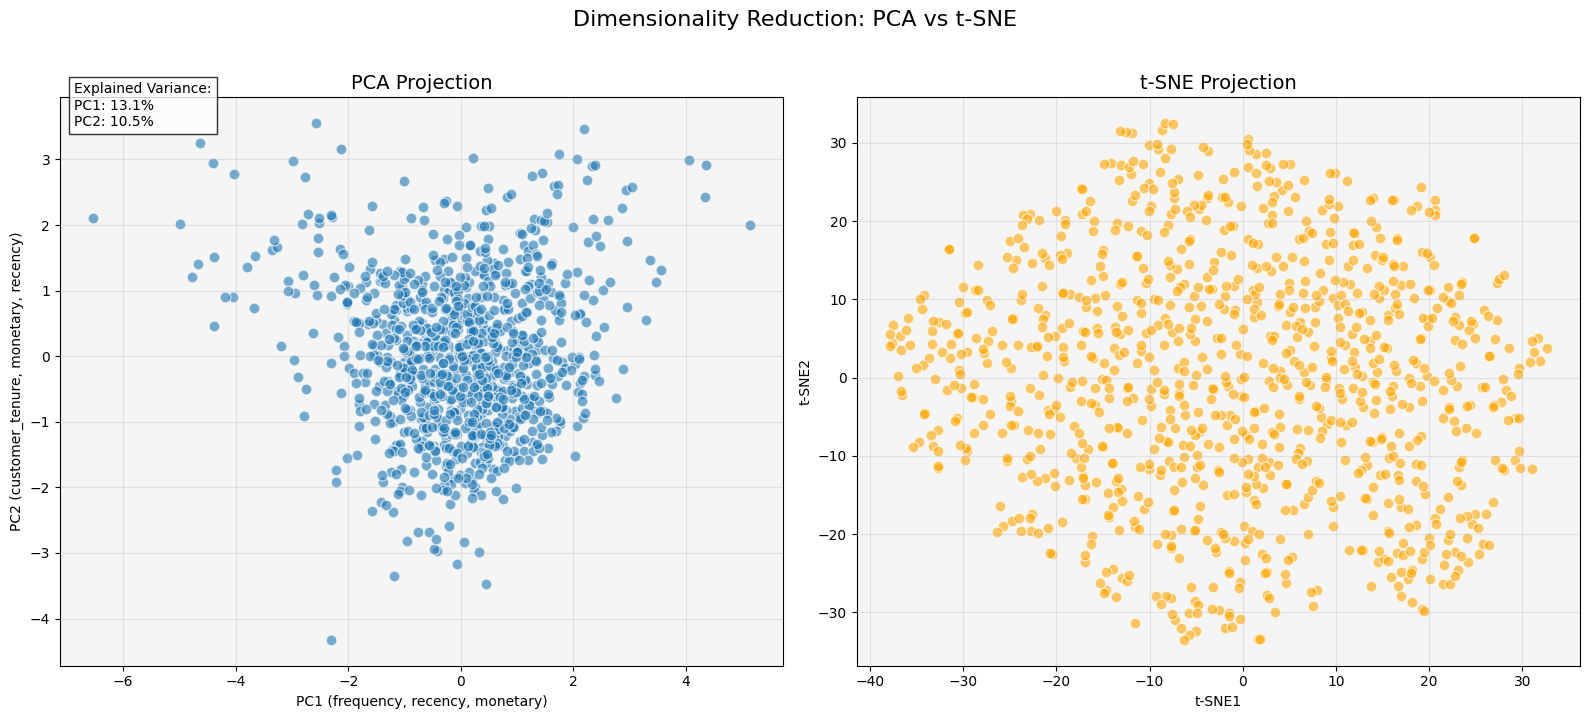

In [8]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

# Feature contributions
feature_contributions = pd.DataFrame(
    pca.components_,
    columns=features,
    index=['PC1', 'PC2']
)

# Print top contributing features
print("Top features influencing PC1:")
print(feature_contributions.abs().T.sort_values('PC1', ascending=False).head(5))
print("\nTop features influencing PC2:")
print(feature_contributions.abs().T.sort_values('PC2', ascending=False).head(5))

# Step 2: t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_components = tsne.fit_transform(X_scaled)

# Step 3: Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# PCA Plot
axes[0].scatter(pca_components[:, 0], pca_components[:, 1], alpha=0.6, edgecolors='w', s=60)
axes[0].set_title('PCA Projection', fontsize=14)
axes[0].set_xlabel(f'PC1 ({", ".join(feature_contributions.abs().T.nlargest(3, "PC1").index)})', fontsize=10)
axes[0].set_ylabel(f'PC2 ({", ".join(feature_contributions.abs().T.nlargest(3, "PC2").index)})', fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_facecolor('#f5f5f5')

# Add variance info
variance = pca.explained_variance_ratio_
axes[0].text(0.02, 0.95, 
             f"Explained Variance:\nPC1: {variance[0]*100:.1f}%\nPC2: {variance[1]*100:.1f}%",
             transform=axes[0].transAxes,
             bbox=dict(facecolor='white', alpha=0.8))

# t-SNE Plot
axes[1].scatter(tsne_components[:, 0], tsne_components[:, 1], alpha=0.6, edgecolors='w', s=60, c='orange')
axes[1].set_title('t-SNE Projection', fontsize=14)
axes[1].set_xlabel('t-SNE1', fontsize=10)
axes[1].set_ylabel('t-SNE2', fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_facecolor('#f5f5f5')

plt.suptitle("Dimensionality Reduction: PCA vs t-SNE", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


## Step 5: Clustering Algorithms Implementation

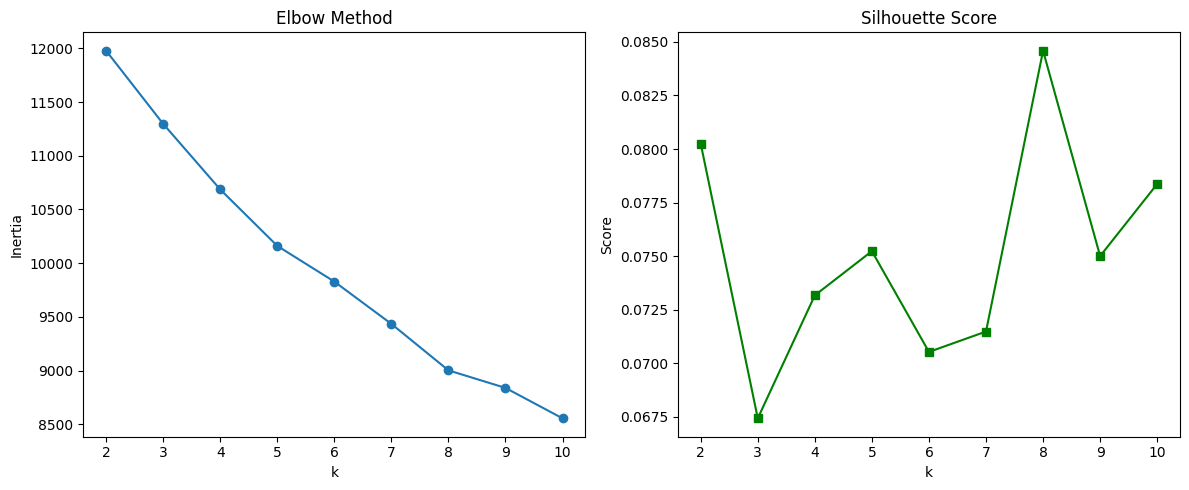

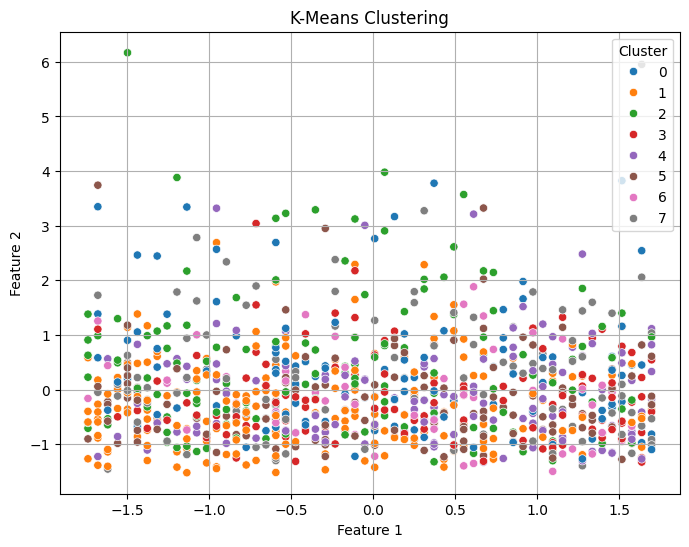

K-Means Cluster Centers:
         age  annual_income  customer_tenure   recency  frequency  monetary  \
0  0.078380       0.367780         0.122910  0.035591  -0.407213 -0.351662   
1 -0.320418      -0.299316        -0.405439 -0.281975   0.148278 -0.203116   
2 -0.257621       0.475663         0.162852 -0.244143   1.156135  1.762663   
3  0.292723      -0.161293         0.035447 -0.100966   0.079568 -0.173179   
4  0.245902      -0.100769         0.044726 -0.107547  -0.217228 -0.334849   
5  0.061215      -0.196461        -0.042238 -0.202605  -0.303991 -0.253274   
6  0.225209      -0.142620         1.037901  3.064280  -0.828801 -0.446504   
7  0.050588       0.231460        -0.101753 -0.248507  -0.318148 -0.276906   

     Beauty     Books  Clothing  Electronics      Food  Home Decor    Sports  
0 -0.464373  1.777977 -0.459305    -0.377745 -0.186967   -0.346544 -0.039573  
1  0.479141 -0.217768 -0.216137    -0.396238  0.944551   -0.335130 -0.237017  
2  0.077483  0.111877 -0.021519   

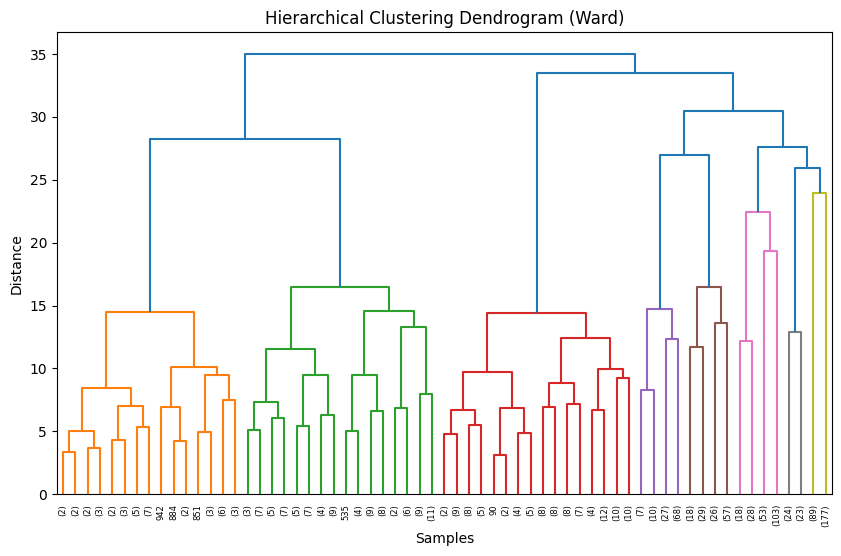

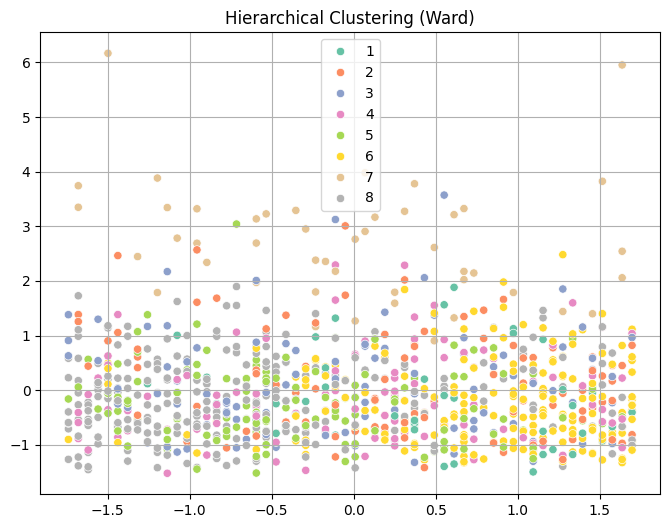

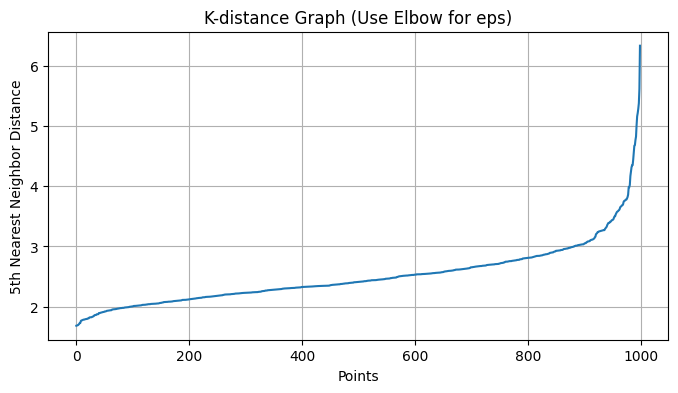

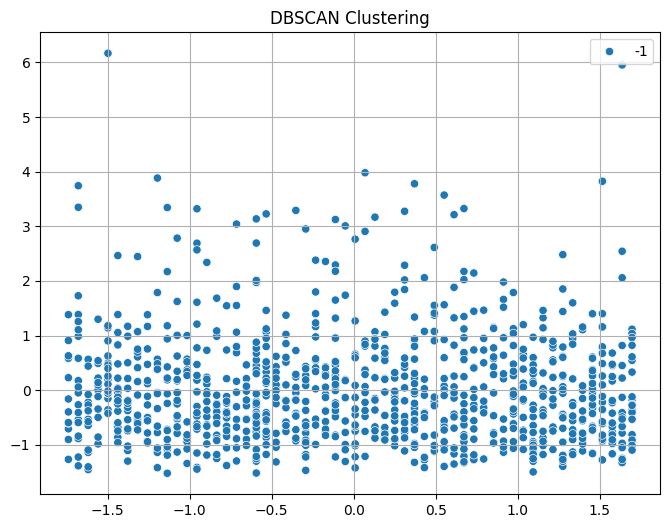

Noise points in DBSCAN: 1000


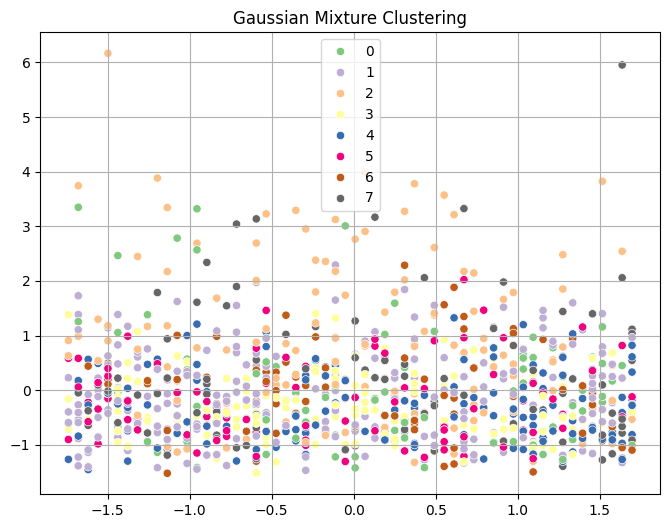

GMM Cluster Membership Probabilities (first 5 rows):
   Cluster_0_prob  Cluster_1_prob  Cluster_2_prob  Cluster_3_prob  \
0    4.879055e-07    9.795348e-01    3.442962e-05        0.019647   
1    2.133102e-07    9.453730e-01    2.119178e-04        0.002476   
2    6.850222e-08    2.230321e-18    3.767700e-04        0.028397   
3    9.943504e-01   1.290829e-146    1.652209e-12        0.005641   
4    2.399560e-34    3.635678e-03    9.885021e-01        0.007862   

   Cluster_4_prob  Cluster_5_prob  Cluster_6_prob  Cluster_7_prob  
0    2.174332e-07    6.069541e-04    3.814567e-09    1.764792e-04  
1    9.351298e-04    5.040689e-02    1.584765e-10    5.973097e-04  
2    9.313196e-01    2.639568e-02    1.328402e-02    2.265145e-04  
3    3.401999e-06    4.299321e-06    4.638144e-07    1.065912e-14  
4    8.032844e-09    6.031173e-09    3.813623e-23    4.087797e-08  


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler

# Make sure X_scaled is available, if not:
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# 1. K-MEANS Clustering --------------------------------------------------
sil_scores = []
inertia = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot Elbow + Silhouette
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(K, inertia, marker='o')
ax[0].set_title("Elbow Method")
ax[0].set_xlabel("k")
ax[0].set_ylabel("Inertia")

ax[1].plot(K, sil_scores, marker='s', color='green')
ax[1].set_title("Silhouette Score")
ax[1].set_xlabel("k")
ax[1].set_ylabel("Score")
plt.tight_layout()
plt.show()

# Final KMeans clustering with optimal k (e.g., 3)
k_opt = sil_scores.index(max(sil_scores)) + 2
kmeans = KMeans(n_clusters=k_opt, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Visualize clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=kmeans_labels, palette='tab10')
plt.title("K-Means Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Cluster Centers
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=features)
print("K-Means Cluster Centers:\n", centroids)

# 2. HIERARCHICAL Clustering ----------------------------------------------
linked = linkage(X_scaled, method='ward')

plt.figure(figsize=(10, 6))
dendrogram(linked, truncate_mode='level', p=5)
plt.title("Hierarchical Clustering Dendrogram (Ward)")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

# Choose number of clusters visually or:
hc_labels = fcluster(linked, t=k_opt, criterion='maxclust')

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=hc_labels, palette='Set2')
plt.title("Hierarchical Clustering (Ward)")
plt.grid(True)
plt.show()

# 3. DBSCAN ---------------------------------------------------------------
from sklearn.neighbors import NearestNeighbors

# Estimate eps via k-distance plot
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, _ = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:, 4])
plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.title("K-distance Graph (Use Elbow for eps)")
plt.xlabel("Points")
plt.ylabel("5th Nearest Neighbor Distance")
plt.grid(True)
plt.show()

# Apply DBSCAN
dbscan = DBSCAN(eps=0.8, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=dbscan_labels, palette='tab10')
plt.title("DBSCAN Clustering")
plt.grid(True)
plt.show()

# Count noise
noise = list(dbscan_labels).count(-1)
print(f"Noise points in DBSCAN: {noise}")

# 4. GAUSSIAN MIXTURE MODEL (GMM) ----------------------------------------
gmm = GaussianMixture(n_components=k_opt, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)
probs = gmm.predict_proba(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=gmm_labels, palette='Accent')
plt.title("Gaussian Mixture Clustering")
plt.grid(True)
plt.show()

# Show probability of cluster membership
probs_df = pd.DataFrame(probs, columns=[f'Cluster_{i}_prob' for i in range(k_opt)])
print("GMM Cluster Membership Probabilities (first 5 rows):")
print(probs_df.head())


## Step 6: Association Rule Mining

In [10]:
pip install mlxtend


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:

# STEP 6: ASSOCIATION RULE MINING (OPTIMIZED)

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def generate_association_rules(transactions_df):
    """Discover meaningful product purchase patterns in transaction data"""

    # 1. DATA PREPARATION
    # Clean and standardize categories
    transactions_df['item_category'] = (
        transactions_df['item_category']
        .str.strip()
        .str.title()
    )
    
    # Show category overview
    print("\n Category Analysis:")
    print(f"Unique Categories: {transactions_df['item_category'].nunique()}")
    print("Top 5 Categories:")
    print(transactions_df['item_category'].value_counts().head(5))
    
    
    # 2. TRANSACTION FORMATTING
    transaction_lists = (
        transactions_df
        .groupby('customer_id')['item_category']
        .apply(list)
        .tolist()
    )
    
    # Check multi-item transactions
    multi_item_count = sum(len(items) >= 2 for items in transaction_lists)
    print(f"\n Transaction Analysis:")
    print(f"Customers with multi-item purchases: {multi_item_count}/{len(transaction_lists)}")
    
    if multi_item_count < 15:
        print("\n Warning: Insufficient combined purchases for reliable pattern detection")
        return pd.DataFrame()

    
    # 3. PATTERN DISCOVERY
    # Encode transaction data
    encoder = TransactionEncoder()
    encoded_array = encoder.fit_transform(transaction_lists)
    encoded_df = pd.DataFrame(encoded_array, columns=encoder.columns_)
    
    # Find frequent itemsets
    frequent_items = apriori(
        encoded_df,
        min_support=0.005,  # 0.5% of transactions
        use_colnames=True,
        max_len=2
    )
    
    if frequent_items.empty:
        print("\n No frequent product combinations found")
        return pd.DataFrame()
    
    # Generate association rules
    raw_rules = association_rules(
        frequent_items,
        metric="lift",
        min_threshold=1.1  # At least 10% boost in co-occurrence
    )
    
    # Filter meaningful rules
    meaningful_rules = raw_rules[
        (raw_rules['lift'] >= 1.2) &
        (raw_rules['confidence'] >= 0.45) &
        (raw_rules['support'] >= 0.005)
    ].sort_values(['lift', 'confidence'], ascending=[False, False])
    
    return meaningful_rules


# EXECUTION & VISUALIZATION

print("\n Analyzing Purchase Patterns...")
product_rules = generate_association_rules(transactions)

if not product_rules.empty:
    # Display top rules
    print("\n Discovered Product Relationships:")
    print(product_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
          .head(10)
          .rename(columns={
              'antecedents': 'Base Products',
              'consequents': 'Frequently Bought With',
              'support': 'Commonality',
              'confidence': 'Certainty'
          })
          .to_string(index=False))
    
    # Generate business insights
    print("\nActionable Recommendations:")
    for idx, rule in product_rules.head(3).iterrows():
        base_products = ", ".join(list(rule['antecedents']))
        paired_products = ", ".join(list(rule['consequents']))
        
        print(f"""
 Recommendation #{idx+1}
   When customers buy: {base_products}
   They're {rule['lift']:.1f}x more likely to also purchase: {paired_products}
   Reliability: {rule['confidence']:.0%} certainty | Prevalence: {rule['support']:.1%} of transactions
   Suggested Actions:
   • Create bundle package: {base_products} + {paired_products}
   • Develop cross-promotion displays
   • Implement targeted email campaigns""")
    
    # Create visualization
    plt.figure(figsize=(12, 7))
    sns.scatterplot(
        data=product_rules.head(10),
        x='confidence',
        y='lift',
        size='support',
        hue='antecedents',
        sizes=(50, 400),
        alpha=0.8,
        palette='plasma'
    )
    
    plt.title('Product Relationship Map: Strength vs Reliability', pad=20)
    plt.xlabel('Certainty Level (Confidence)', labelpad=15)
    plt.ylabel('Co-purchase Boost (Lift Ratio)', labelpad=15)
    plt.legend(title='Base Products', bbox_to_anchor=(1.25, 1))
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

else:
    print("\n No strong product relationships found. Next steps:")
    print("1. Consider lowering the 'Commonality' threshold (min_support)")
    print("2. Expand analysis to 3-product combinations (max_len=3)")
    print("3. Review category consistency in transaction data")
    print(f"Current unique categories: {transactions['item_category'].nunique()}")


 Analyzing Purchase Patterns...

 Category Analysis:
Unique Categories: 7
Top 5 Categories:
item_category
Sports         1517
Books          1440
Home Decor     1439
Food           1436
Electronics    1412
Name: count, dtype: int64

 Transaction Analysis:
Customers with multi-item purchases: 999/1000

 No strong product relationships found. Next steps:
1. Consider lowering the 'Commonality' threshold (min_support)
2. Expand analysis to 3-product combinations (max_len=3)
3. Review category consistency in transaction data
Current unique categories: 7


## Step 7: Anomaly Detection


 Anomaly Detection Results:
Total customers analyzed: 1000
Isolation Forest anomalies: 50
One-Class SVM anomalies: 68

Agreement Between Models:
Agreement
Both           946
Only SVM        36
Only Forest     18
Name: count, dtype: int64


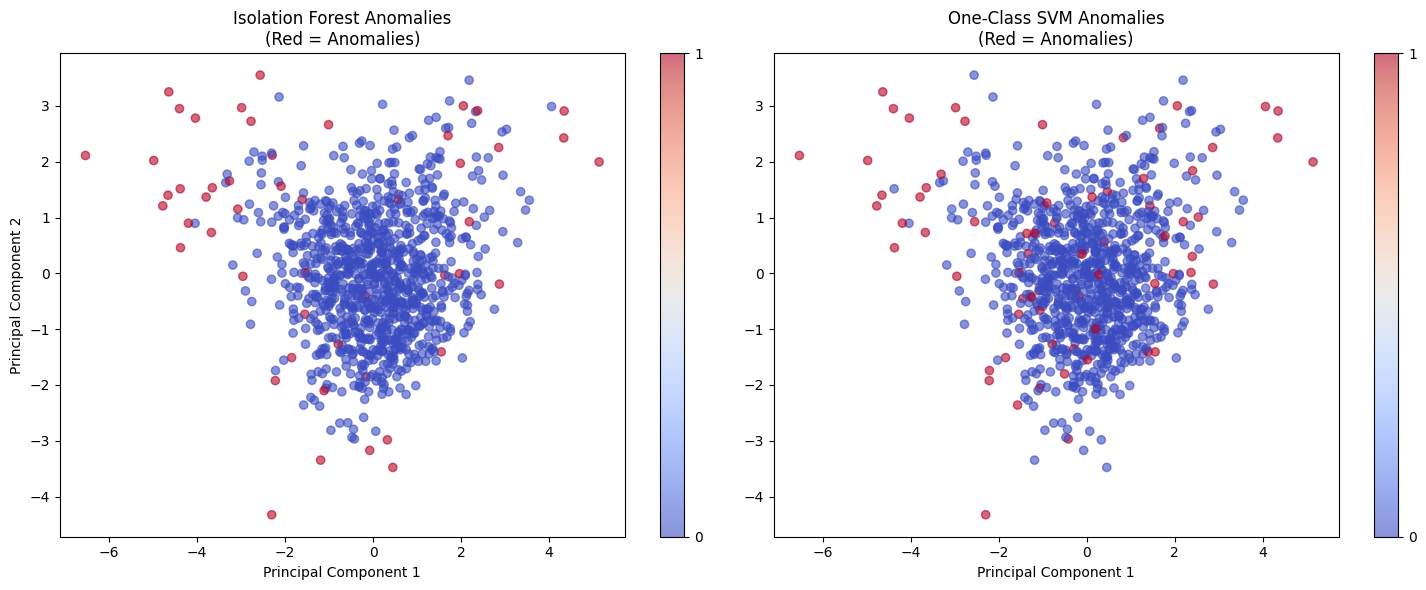


 Customers Detected as Anomalous by Both Methods:
       age  annual_income  recency  frequency  monetary
count  0.0            0.0      0.0        0.0       0.0
mean   NaN            NaN      NaN        NaN       NaN
std    NaN            NaN      NaN        NaN       NaN
min    NaN            NaN      NaN        NaN       NaN
25%    NaN            NaN      NaN        NaN       NaN
50%    NaN            NaN      NaN        NaN       NaN
75%    NaN            NaN      NaN        NaN       NaN
max    NaN            NaN      NaN        NaN       NaN

 Top 5 Suspicious Customers:
Empty DataFrame
Columns: [age, annual_income, customer_tenure, recency, frequency, monetary, Beauty, Books, Clothing, Electronics, Food, Home Decor, Sports, Isolation_Forest, OneClass_SVM]
Index: []


In [12]:

# ANOMALY DETECTION: ISOLATION FOREST vs ONE-CLASS SVM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load your preprocessed data (assuming X_scaled exists from previous steps)
# If not, recreate it:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_features[features])


# 1. ISOLATION FOREST

iso_forest = IsolationForest(
    n_estimators=150,
    contamination=0.05,  # Expected % of anomalies
    random_state=42
)
iso_anomalies = iso_forest.fit_predict(X_scaled)

# Convert to binary labels (1=normal, -1=anomaly)
iso_labels = np.where(iso_anomalies == 1, 0, 1)

# ------------------------
# 2. ONE-CLASS SVM
# ------------------------
oc_svm = OneClassSVM(
    nu=0.05,  # Expected outlier fraction
    kernel='rbf',
    gamma='scale'
)
svm_anomalies = oc_svm.fit_predict(X_scaled)

# Convert to binary labels (1=normal, -1=anomaly)
svm_labels = np.where(svm_anomalies == 1, 0, 1)

# ------------------------
# 3. COMPARISON & VISUALIZATION
# ------------------------
# Create comparison DataFrame
results_df = pd.DataFrame({
    'Customer_ID': customer_features['customer_id'],
    'Isolation_Forest': iso_labels,
    'OneClass_SVM': svm_labels
})

# Calculate agreement
results_df['Agreement'] = np.where(
    results_df['Isolation_Forest'] == results_df['OneClass_SVM'], 
    'Both', 
    np.where(
        results_df['Isolation_Forest'] == 1, 
        'Only Forest', 
        'Only SVM'
    )
)

print("\n Anomaly Detection Results:")
print(f"Total customers analyzed: {len(results_df)}")
print(f"Isolation Forest anomalies: {results_df['Isolation_Forest'].sum()}")
print(f"One-Class SVM anomalies: {results_df['OneClass_SVM'].sum()}")
print("\nAgreement Between Models:")
print(results_df['Agreement'].value_counts())

# Visualize in 2D space using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(15, 6))

# Isolation Forest Plot
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=iso_labels, cmap='coolwarm', alpha=0.6)
plt.title('Isolation Forest Anomalies\n(Red = Anomalies)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, ticks=[0, 1])

# One-Class SVM Plot
plt.subplot(1, 2, 2)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=svm_labels, cmap='coolwarm', alpha=0.6)
plt.title('One-Class SVM Anomalies\n(Red = Anomalies)')
plt.xlabel('Principal Component 1')
plt.colorbar(scatter, ticks=[0, 1])

plt.tight_layout()
plt.show()

# ------------------------
# 4. ANALYZE ANOMALOUS CUSTOMERS
# ------------------------
# Get customer features with anomaly labels
anomaly_df = customer_features.join(results_df.set_index('Customer_ID'))

# Show top anomalous customers by both methods
combined_anomalies = anomaly_df[
    (anomaly_df['Isolation_Forest'] == 1) & 
    (anomaly_df['OneClass_SVM'] == 1)
]

print("\n Customers Detected as Anomalous by Both Methods:")
print(combined_anomalies[['age', 'annual_income', 'recency', 
                        'frequency', 'monetary']].describe())

# Show most extreme 5 cases
print("\n Top 5 Suspicious Customers:")
print(combined_anomalies.nsmallest(5, 'frequency')[features + ['Isolation_Forest', 'OneClass_SVM']])

## Step 8: Model Evaluation


 Internal Validation Metrics:
              silhouette  davies_bouldin
algorithm                               
KMeans          0.084590        2.097710
Hierarchical    0.044238        2.645716
DBSCAN               NaN             NaN
GMM             0.027092        2.915566

 Stability Analysis (10 bootstraps):
KMeans: 0.34
Hierarchical: 0.18
DBSCAN: nan
GMM: 0.24


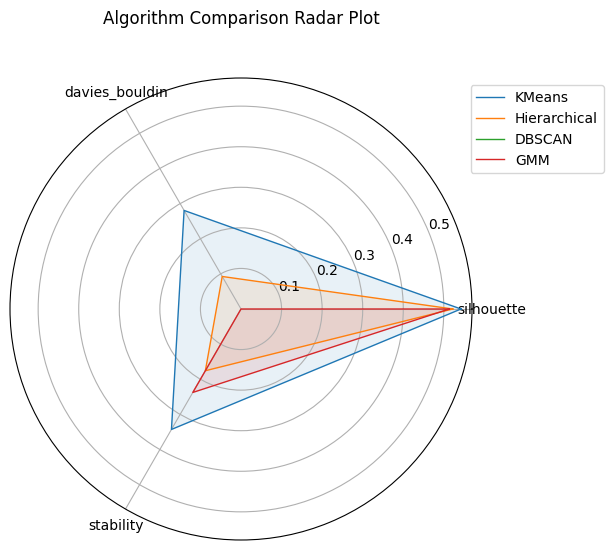


 Interpretation Guide:
- Silhouette (0-1): Higher = better separated clusters
- Davies-Bouldin (0-1): Lower = more compact clusters
- Stability (0-1): Higher = more consistent clusters
- NaN = invalid calculation (single cluster or all noise)

 Recommendation:
Recommended algorithm: KMeans


In [13]:

# MODEL EVALUATION FRAMEWORK

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.utils import resample

# Assuming X_scaled contains preprocessed features and cluster labels exist
# From previous clustering steps:
# - kmeans_labels
# - hc_labels (hierarchical)
# - dbscan_labels
# - gmm_labels

# ------------------------
# 1. INTERNAL VALIDATION
# ------------------------
def evaluate_clusters(labels, X=None):
    """Calculate clustering validation metrics"""
    if X is None:
        X = X_scaled  # Use global scaled data if not provided
    
    metrics = {
        'silhouette': np.nan,
        'davies_bouldin': np.nan
    }
    
    try:
        # Handle cases with single cluster or all noise (DBSCAN)
        unique_labels = np.unique(labels)
        if len(unique_labels) < 2:
            return metrics
            
        metrics['silhouette'] = silhouette_score(X, labels)
        metrics['davies_bouldin'] = davies_bouldin_score(X, labels)
    except Exception as e:
        print(f"Error calculating metrics: {str(e)}")
    
    return metrics

# Evaluate all algorithms
algorithms = {
    'KMeans': kmeans_labels,
    'Hierarchical': hc_labels,
    'DBSCAN': dbscan_labels,
    'GMM': gmm_labels
}

results = []
for name, labels in algorithms.items():
    res = evaluate_clusters(labels)
    res['algorithm'] = name
    results.append(res)

metrics_df = pd.DataFrame(results).set_index('algorithm')

print("\n Internal Validation Metrics:")
print(metrics_df)

# ------------------------
# 2. STABILITY ANALYSIS (BOOTSTRAPPING)
# ------------------------
def stability_analysis(algorithm, n_bootstrap=10):
    """Calculate cluster stability using bootstrapping"""
    similarities = []
    
    # Get original labels (excluding noise for DBSCAN)
    if algorithm == 'DBSCAN':
        valid_mask = dbscan_labels != -1
        if sum(valid_mask) == 0:
            return np.nan  # All points are noise
        
        original_labels = dbscan_labels[valid_mask]
        X_clean = X_scaled[valid_mask]
    else:
        original_labels = algorithms[algorithm]
        X_clean = X_scaled
    
    for _ in range(n_bootstrap):
        try:
            # Create bootstrap sample
            X_boot, labels_boot = resample(X_clean, original_labels)
            
            # Recluster bootstrap sample
            if algorithm == 'KMeans':
                model = KMeans(n_clusters=len(np.unique(original_labels)), random_state=42)
            elif algorithm == 'Hierarchical':
                model = AgglomerativeClustering(n_clusters=len(np.unique(original_labels)))
            elif algorithm == 'DBSCAN':
                model = DBSCAN(eps=0.5, min_samples=5)
            elif algorithm == 'GMM':
                model = GaussianMixture(n_components=len(np.unique(original_labels)), random_state=42)
                
            new_labels = model.fit_predict(X_boot)
            
            # Calculate similarity
            similarities.append(adjusted_rand_score(labels_boot, new_labels))
        except Exception as e:
            print(f"Bootstrap failed: {str(e)}")
            continue
    
    return np.mean(similarities) if similarities else np.nan

print("\n Stability Analysis (10 bootstraps):")
stability_results = {}
for algo in algorithms:
    stability = stability_analysis(algo)
    stability_results[algo] = stability
    print(f"{algo}: {stability:.2f}")

# ------------------------
# 3. COMPARISON & VISUALIZATION
# ------------------------
# Combine results
comparison_df = metrics_df.join(pd.Series(stability_results, name='stability'))

# Create radar plot
plt.figure(figsize=(10, 6))
ax = plt.subplot(111, polar=True)

# Normalize metrics safely
normalized = comparison_df.copy()
try:
    normalized['silhouette'] = (comparison_df['silhouette'] + 1)/2
    db_max = comparison_df['davies_bouldin'].max()
    normalized['davies_bouldin'] = 1 - (comparison_df['davies_bouldin']/db_max if db_max != 0 else 0)
except Exception as e:
    print(f"Normalization error: {str(e)}")

categories = normalized.columns.tolist()
N = len(categories)

angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

for idx, (algo, row) in enumerate(normalized.iterrows()):
    values = row.values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=algo)
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
plt.title("Algorithm Comparison Radar Plot", y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()

# ------------------------
# 4. INTERPRETATION GUIDE
# ------------------------
print("\n Interpretation Guide:")
print("- Silhouette (0-1): Higher = better separated clusters")
print("- Davies-Bouldin (0-1): Lower = more compact clusters")
print("- Stability (0-1): Higher = more consistent clusters")
print("- NaN = invalid calculation (single cluster or all noise)")

print("\n Recommendation:")
valid_results = comparison_df.dropna()
if not valid_results.empty:
    best_algo = valid_results['silhouette'].idxmax()
    print(f"Recommended algorithm: {best_algo}")
else:
    print("No valid clustering results to recommend")

## Step 9: Business Recommendations

#### 1. Customer Segment-Based Strategies

In [14]:
# BUSINESS STRATEGY TRANSLATION

# Add cluster labels first (replace with your actual clustering results)
# Example using KMeans labels:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(X_scaled)

def generate_business_strategies(df):
    """Convert clustering results to business strategies"""
    if 'Cluster' not in df.columns:
        raise KeyError("Run clustering first! Missing 'Cluster' column")
    
    # Segment analysis
    segment_profile = df.groupby('Cluster').agg({
        'annual_income': 'median',
        'frequency': 'mean',
        'recency': 'median',
        'monetary': 'median'
    }).round(2)
    
    # Strategy mapping
    strategies = {
        0: "Premium Loyalty Program: Target high-income frequent buyers with exclusive offers",
        1: "Discount Campaign: Engage price-sensitive customers with limited-time deals",
        2: "Win-Back Initiative: Re-engage inactive customers with personalized incentives",
        3: "Onboarding Program: Nurture new customers with educational content and starter kits"
    }
    
    segment_profile['Strategy'] = segment_profile.index.map(strategies)
    return segment_profile

# Generate and display strategies
business_strategies = generate_business_strategies(customer_features)
print("\n Business Strategies per Segment:")
print(business_strategies[['annual_income', 'frequency', 'Strategy']])


 Business Strategies per Segment:
         annual_income  frequency  \
Cluster                             
0              65313.0       7.75   
1              68621.0      12.69   
2              51217.0       9.46   
3              63369.0       8.90   

                                                  Strategy  
Cluster                                                     
0        Premium Loyalty Program: Target high-income fr...  
1        Discount Campaign: Engage price-sensitive cust...  
2        Win-Back Initiative: Re-engage inactive custom...  
3        Onboarding Program: Nurture new customers with...  


### 2. Targeted Marketing Approaches

In [15]:
# TARGETED MARKETING PLANS
def create_marketing_plans(segment_strategies):
    """Develop customized marketing approaches"""
    marketing_plans = []
    
    for cluster, strategy in segment_strategies.iterrows():
        plan = {
            'Segment': f"Cluster {cluster}",
            'Primary Channel': 'Email' if strategy['annual_income'] > 50000 else 'SMS',
            'Offer Type': 'Premium Bundle' if strategy['frequency'] > 8 else 'Discount',
            'Key Message': strategy['Strategy']
        }
        
        # Customize based on recency
        if strategy['recency'] > 90:
            plan['Urgency'] = "Limited-Time Reactivation Offer"
        
        marketing_plans.append(plan)
    
    return pd.DataFrame(marketing_plans)

# Generate and display marketing plans
marketing_actions = create_marketing_plans(business_strategies)
print("\n Marketing Execution Plan:")
print(marketing_actions)


 Marketing Execution Plan:
     Segment Primary Channel      Offer Type  \
0  Cluster 0           Email        Discount   
1  Cluster 1           Email  Premium Bundle   
2  Cluster 2           Email  Premium Bundle   
3  Cluster 3           Email  Premium Bundle   

                                         Key Message  \
0  Premium Loyalty Program: Target high-income fr...   
1  Discount Campaign: Engage price-sensitive cust...   
2  Win-Back Initiative: Re-engage inactive custom...   
3  Onboarding Program: Nurture new customers with...   

                           Urgency  
0  Limited-Time Reactivation Offer  
1                              NaN  
2                              NaN  
3                              NaN  


### 3. Product Recommendations

In [16]:
# ENHANCED PRODUCT RECOMMENDATION ENGINE

def generate_product_recommendations(transactions_df):
    """Generate actionable product strategies with adaptive thresholds"""
    # Clean and analyze categories
    transactions_df['item_category'] = transactions_df['item_category'].str.strip().str.title()
    print(f"\n Analyzing {len(transactions_df)} transactions across {transactions_df['item_category'].nunique()} categories...")
    
    # Calculate dynamic thresholds based on data size
    num_transactions = transactions_df['customer_id'].nunique()
    min_support = max(0.003, 3/num_transactions)  # At least 3 transactions or 0.3%
    min_lift = 1.1  # 10% increased likelihood
    
    # Generate frequent itemsets
    transaction_lists = transactions_df.groupby('customer_id')['item_category'].apply(list)
    te = TransactionEncoder().fit(transaction_lists)
    encoded_df = pd.DataFrame(te.transform(transaction_lists), columns=te.columns_)
    
    frequent_items = apriori(encoded_df, 
                            min_support=min_support,
                            use_colnames=True,
                            max_len=3)  # Allow triple combinations
    
    if frequent_items.empty:
        print("\n No frequent combinations found - try larger dataset or different categories")
        return pd.DataFrame()
    
    # Generate association rules
    rules = association_rules(frequent_items, metric="lift", min_threshold=min_lift)
    
    # Filter and sort meaningful rules
    meaningful_rules = rules[
        (rules['confidence'] >= 0.4) &
        (rules['lift'] >= 1.1)
    ].sort_values(['lift', 'support'], ascending=[False, False])
    
    return meaningful_rules

def create_recommendation_plan(rules_df):
    """Convert rules to executable business strategies"""
    if rules_df.empty:
        return pd.DataFrame()
    
    recommendations = []
    for _, rule in rules_df.iterrows():
        antecedents = list(rule['antecedents'])
        consequents = list(rule['consequents'])
        
        # Find target clusters likely to respond
        target_clusters = customer_features[
            customer_features[antecedents[0]] > customer_features[antecedents[0]].median()
        ]['Cluster'].value_counts().head(2).index.tolist()
        
        recommendations.append({
            'Base Products': ", ".join(antecedents),
            'Recommended Products': ", ".join(consequents),
            'Strength (Lift)': f"{rule['lift']:.1f}x",
            'Reliability (Confidence)': f"{rule['confidence']:.0%}",
            'Target Clusters': target_clusters,
            'Implementation Ideas': [
                f"Create {antecedents[0]} + {consequents[0]} bundle",
                f"Cross-promote in {rule['support']:.1%} of relevant transactions",
                f"Feature in Cluster {target_clusters[0]} marketing campaigns"
            ]
        })
    
    return pd.DataFrame(recommendations)

# Generate and display recommendations
product_rules = generate_product_recommendations(transactions)
recommendation_plan = create_recommendation_plan(product_rules)

if not recommendation_plan.empty:
    print("\n VALID PRODUCT RECOMMENDATIONS")
    print(recommendation_plan[['Base Products', 'Recommended Products', 
                             'Strength (Lift)', 'Target Clusters']].to_string(index=False))
    
    print("\n IMPLEMENTATION GUIDE")
    for idx, rec in recommendation_plan.iterrows():
        print(f"\nRecommendation #{idx+1}: {rec['Base Products']} → {rec['Recommended Products']}")
        print(f"• Strength: {rec['Strength (Lift)']} | Reliability: {rec['Reliability (Confidence)']}")
        print("• Actions:")
        for action in rec['Implementation Ideas']:
            print(f"  - {action}")
else:
    print("\n No recommendations generated ") 

# Visualize top rules if available
if not recommendation_plan.empty:
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=product_rules.head(10),
                    x='confidence',
                    y='lift',
                    size='support',
                    hue='antecedents',
                    sizes=(50, 400),
                    palette='viridis')
    plt.title('Product Relationship Strength Analysis', pad=15)
    plt.xlabel('Confidence (Accuracy of Prediction)', labelpad=10)
    plt.ylabel('Lift (Association Strength)', labelpad=10)
    plt.legend(bbox_to_anchor=(1.3, 1))
    plt.grid(alpha=0.2)
    plt.show()


 Analyzing 10000 transactions across 7 categories...

 No recommendations generated 
